## Getting the Essential Libraries

In [47]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
import warnings
warnings.filterwarnings("ignore")

## Loading the Dataset

In [48]:
dataset = pd.read_csv('PM-Dataset.csv')

In [49]:
dataset

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [50]:
dataset['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

## Data Preprocessing and Little Cleaning

In [51]:
dataset = dataset.drop(['UDI', 'Product ID'], axis=1) # UDI and Product ID droped as it wont be productive while giving results.

In [52]:
# Converting Temperature in Kelvin into Celcius
dataset['Air temperature [K]'] = dataset['Air temperature [K]'] - 272.15
dataset['Process temperature [K]'] = dataset['Process temperature [K]'] - 272.15

In [53]:
dataset.rename(columns={"Air temperature [K]":"Air temperature [C]", "Process temperature [K]":"Process temperature [C]"}, inplace=True)

In [54]:
dataset["Temperature Difference [C]"] = dataset['Process temperature [C]'] - dataset['Air temperature [C]']

In [55]:
dataset.sample(6).style.set_properties(
    **{
        'background-color': 'yellow',
        'color': 'black',
        'border-color': 'black',
        "font-weight": "600"
    })

,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature Difference [C]
9247,L,26.150000,36.750000,1695,30.700000,174,0,No Failure,10.600000
4321,L,29.550000,38.050000,1686,28.900000,59,0,No Failure,8.500000
2550,L,27.250000,37.150000,1366,48.400000,116,0,No Failure,9.900000
4022,L,29.950000,38.750000,1666,30.700000,203,0,No Failure,8.800000
1432,L,26.650000,37.650000,1437,42.800000,23,0,No Failure,11.000000
26,L,26.950000,37.350000,1512,39.000000,75,0,No Failure,10.400000


In [56]:
dataset.describe()

,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Temperature Difference [C]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,27.854930,37.855560,1538.776100,39.986910,107.951000,0.033900,10.000630
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,1.001094
min,23.150000,33.550000,1168.000000,3.800000,0.000000,0.000000,7.600000
25%,26.150000,36.650000,1423.000000,33.200000,53.000000,0.000000,9.300000
50%,27.950000,37.950000,1503.000000,40.100000,108.000000,0.000000,9.800000
75%,29.350000,38.950000,1612.000000,46.800000,162.000000,0.000000,11.000000
max,32.350000,41.650000,2886.000000,76.600000,253.000000,1.000000,12.100000


## Insights about Dataset and Correcting the Failure Type and Target Column

In [57]:
dataset.info() # No Zero/NULL Values in any column or row

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Type                        10000 non-null  object 
 1   Air temperature [C]         10000 non-null  float64
 2   Process temperature [C]     10000 non-null  float64
 3   Rotational speed [rpm]      10000 non-null  int64  
 4   Torque [Nm]                 10000 non-null  float64
 5   Tool wear [min]             10000 non-null  int64  
 6   Target                      10000 non-null  int64  
 7   Failure Type                10000 non-null  object 
 8   Temperature Difference [C]  10000 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 703.3+ KB


In [58]:
dataset.describe()

,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Temperature Difference [C]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,27.854930,37.855560,1538.776100,39.986910,107.951000,0.033900,10.000630
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,1.001094
min,23.150000,33.550000,1168.000000,3.800000,0.000000,0.000000,7.600000
25%,26.150000,36.650000,1423.000000,33.200000,53.000000,0.000000,9.300000
50%,27.950000,37.950000,1503.000000,40.100000,108.000000,0.000000,9.800000
75%,29.350000,38.950000,1612.000000,46.800000,162.000000,0.000000,11.000000
max,32.350000,41.650000,2886.000000,76.600000,253.000000,1.000000,12.100000


In [59]:
# Let's Learn a little about Failure Type and Target.
dataset['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [60]:
dataset['Target'].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

In [61]:
# Digging Deep into Imbalance of Target and Failure Type
df_failure = dataset[dataset['Target'] == 1]

In [62]:
df_failure['Failure Type'].value_counts()

Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64

In [63]:
df_no_failure = dataset[dataset['Target'] == 0]

In [64]:
df_no_failure['Failure Type'].value_counts()

Failure Type
No Failure         9643
Random Failures      18
Name: count, dtype: int64

In [65]:
index_possible_failure = df_failure[df_failure['Failure Type'] == 'No Failure'].index
dataset.drop(index_possible_failure, axis=0, inplace=True)

In [66]:
index_possible_failure = df_no_failure[df_no_failure['Failure Type'] == 'Random Failures'].index
dataset.drop(index_possible_failure, axis=0, inplace=True)

In [67]:
dataset

,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature Difference [C]
0,M,25.95,36.45,1551,42.8,0,0,No Failure,10.5
1,L,26.05,36.55,1408,46.3,3,0,No Failure,10.5
2,L,25.95,36.35,1498,49.4,5,0,No Failure,10.4
3,L,26.05,36.45,1433,39.5,7,0,No Failure,10.4
4,L,26.05,36.55,1408,40.0,9,0,No Failure,10.5
...,...,...,...,...,...,...,...,...,...
9995,M,26.65,36.25,1604,29.5,14,0,No Failure,9.6
9996,H,26.75,36.25,1632,31.8,17,0,No Failure,9.5
9997,M,26.85,36.45,1645,33.4,22,0,No Failure,9.6
9998,H,26.85,36.55,1408,48.5,25,0,No Failure,9.7


In [68]:
dataset.shape[0]

9973

In [69]:
dataset.to_csv('df_visualization.csv', index=False)

## Exploratory Data Analysis

### Correlation Analysis

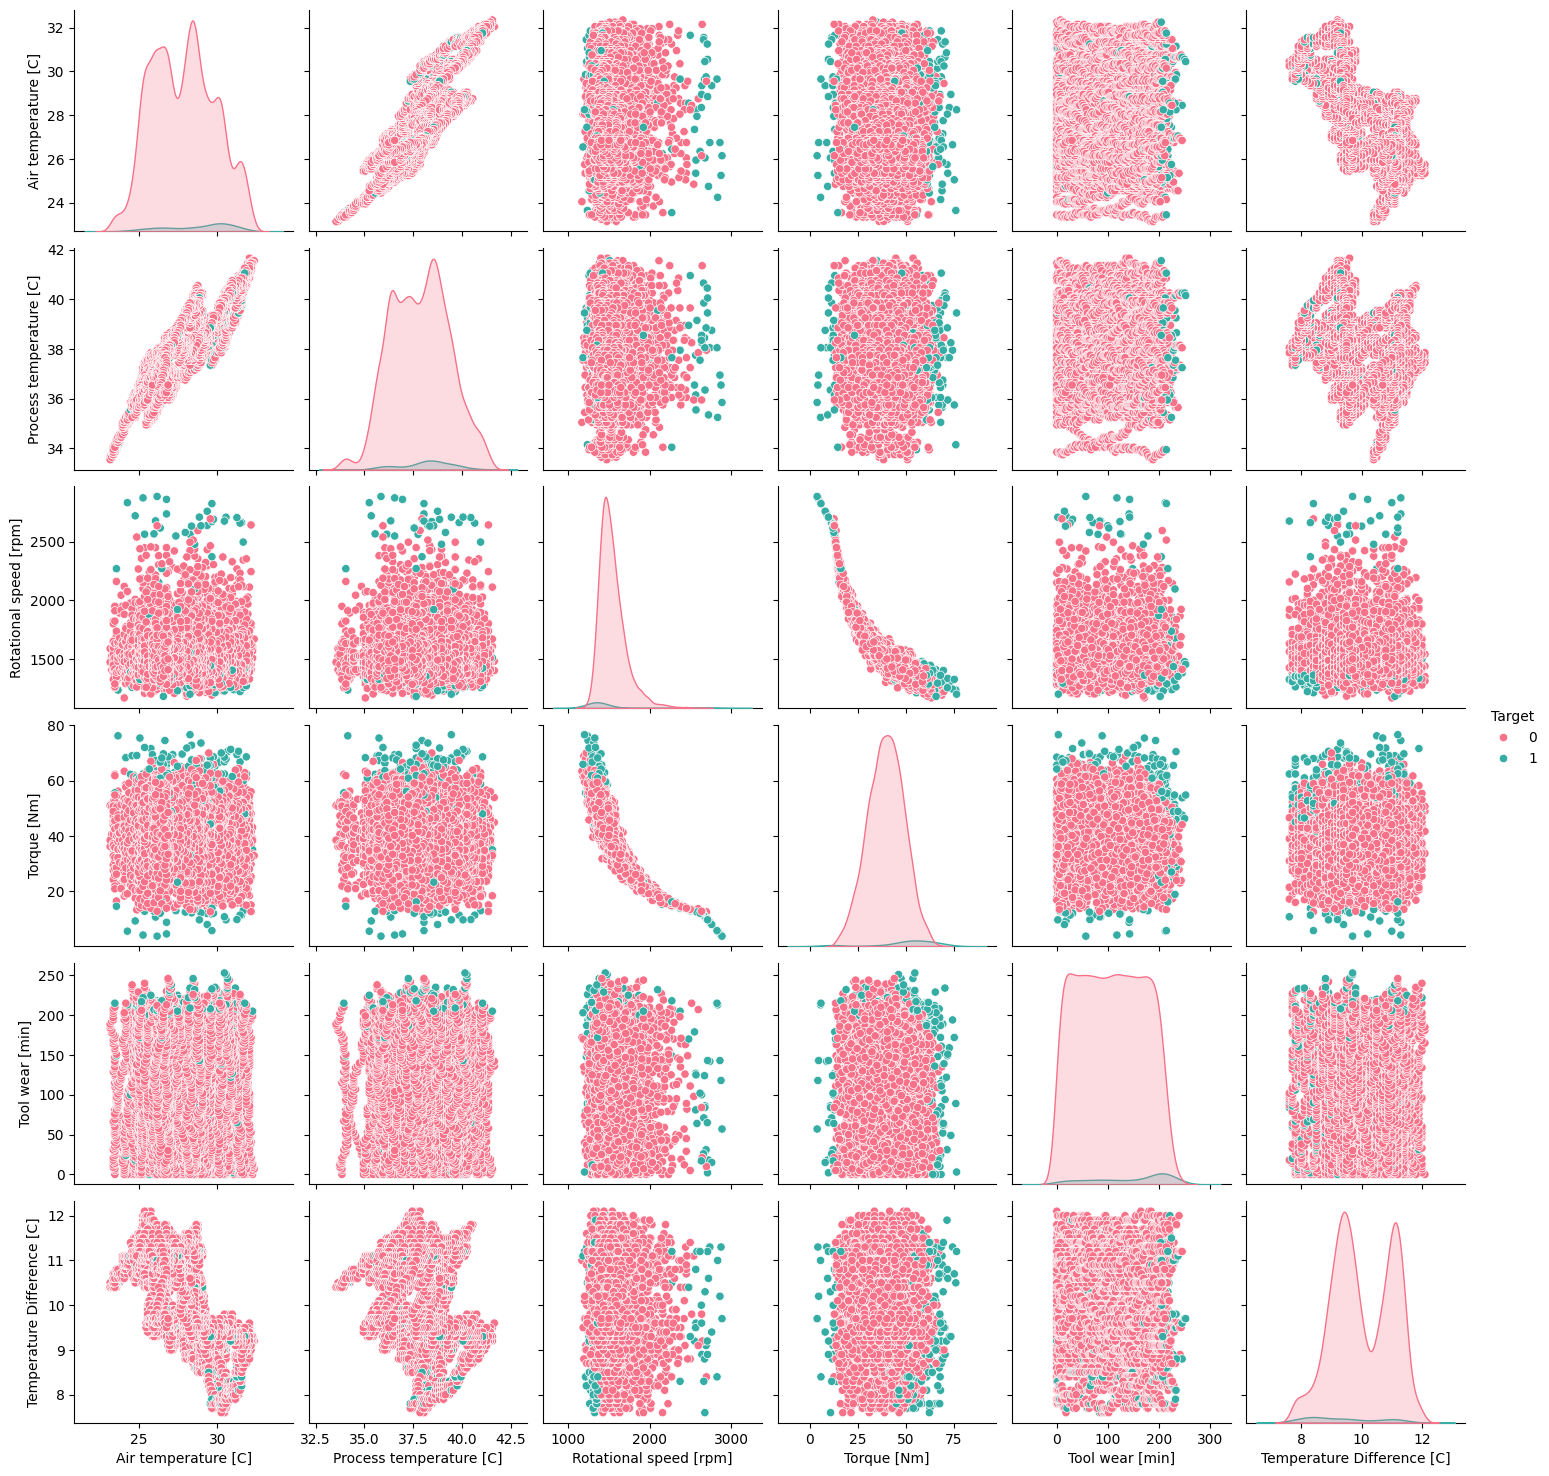

In [70]:
# 1) Numerical Variables pair wise comparision
sns.pairplot(dataset, hue='Target', palette='husl') 
# Good way for finding out correlations.

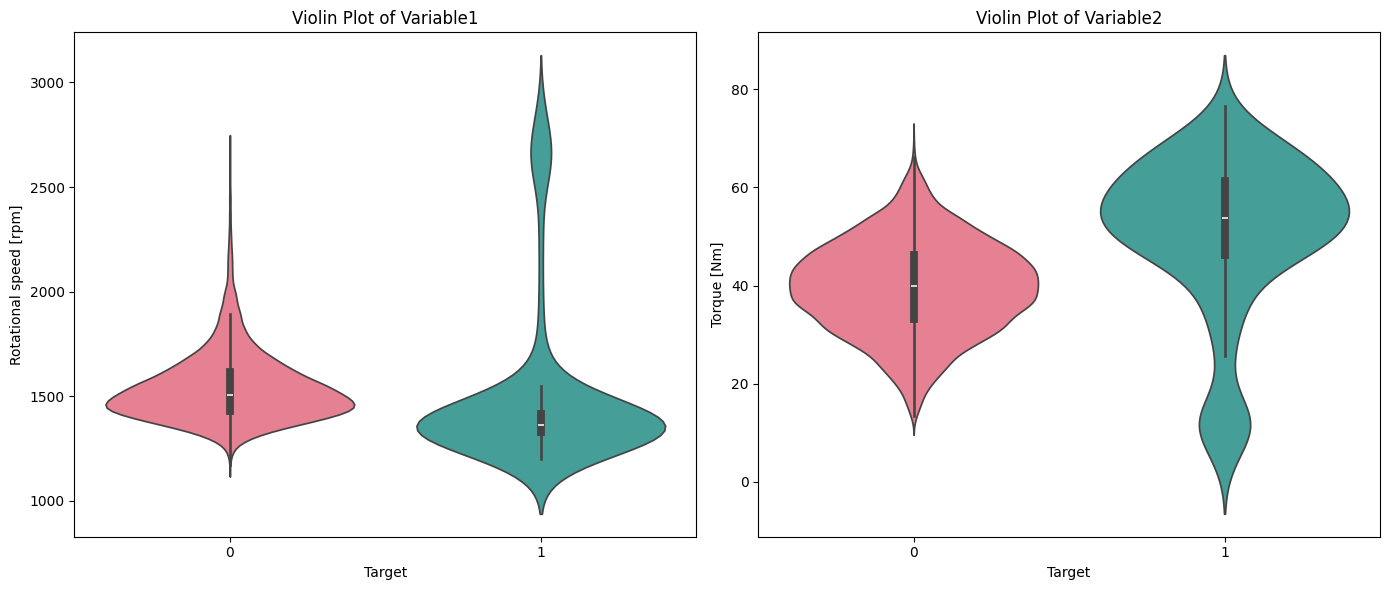

In [71]:
# 2) Violen Plot - To understand the relation of Rotational Speeend and Torque with Target
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(data=dataset, x='Target', y='Rotational speed [rpm]', palette='husl', ax=axes[0])
axes[0].set_title('Violin Plot of Variable1')

sns.violinplot(data=dataset, x='Target', y='Torque [Nm]', palette='husl', ax=axes[1])
axes[1].set_title('Violin Plot of Variable2')

plt.tight_layout()
plt.show()

### Percentage of failure

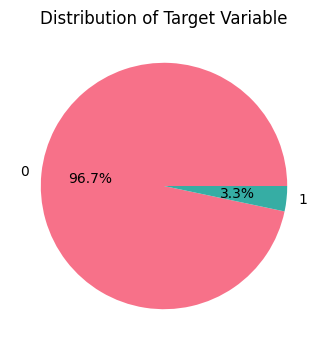

In [72]:
# 3) Pie-Chart - To show the percentage of values in Target Variable.
counts = dataset['Target'].value_counts()
plt.figure(figsize=(4, 4))  
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=sns.color_palette('husl', len(counts)))
plt.title('Distribution of Target Variable')
plt.show()

### Correllation Heatmap

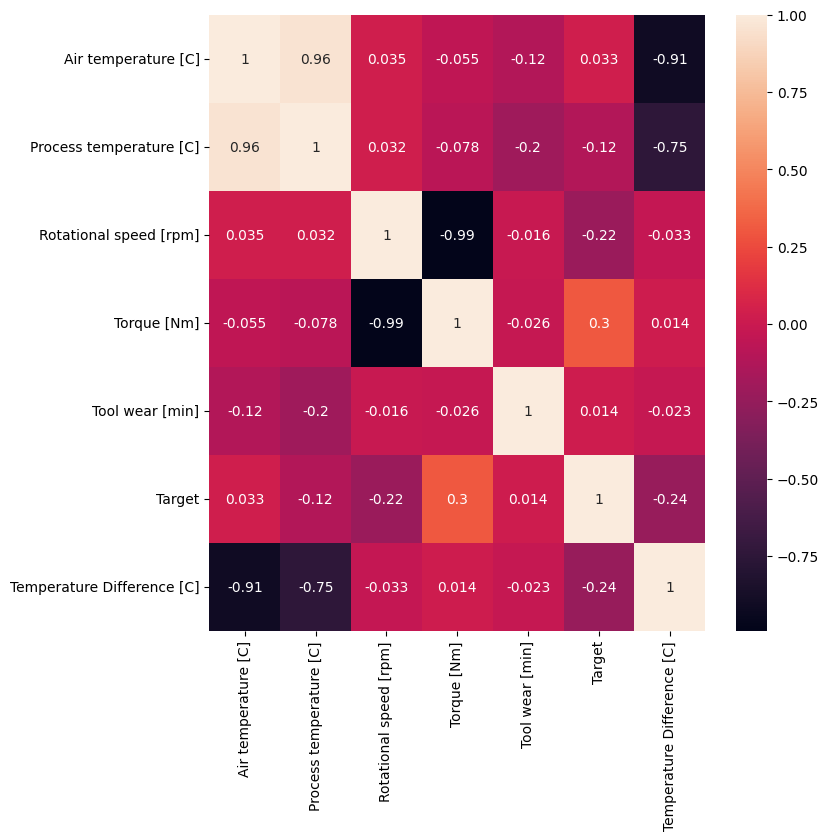

In [73]:
# 3) Heatmap - To study correlation bw all the variables.
numeric_dataset = dataset.select_dtypes(include=['number'])
correlation_matrix = numeric_dataset.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix.corr(), annot=True)
plt.show()

### Product Types

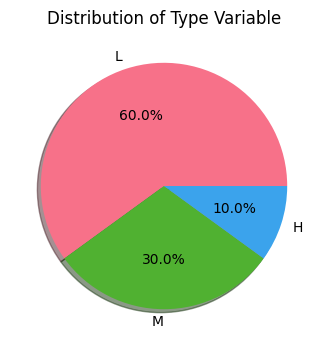

In [74]:
# 5) Pie-Chart - To show the percentage of values in Type Variable.
counts = dataset['Type'].value_counts()
plt.figure(figsize=(4, 4))  
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=sns.color_palette('husl', len(counts)), shadow=True)
plt.title('Distribution of Type Variable')
plt.show()

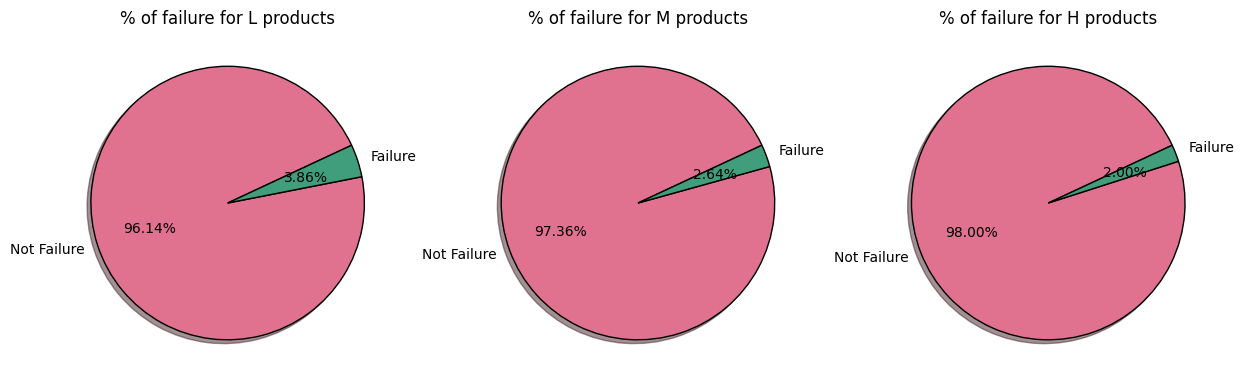

In [75]:
# 6) Pie-Chart - To show Percentage of failure wrt product type
fig, axes = plt.subplots(1,3, figsize=[15,5])
axes.flatten()
j=0
colors = ['#E1728F', '#409E7D'] 
for i in ['L', 'M', 'H']:
    df_product_type = dataset[dataset['Type'] == i]
    axes[j].pie(df_product_type['Target'].value_counts(), labels=['Not Failure', 'Failure'],
                autopct='%1.2f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
                colors=colors)
    axes[j].set_title('% of failure for ' + i + ' products')
    j+=1

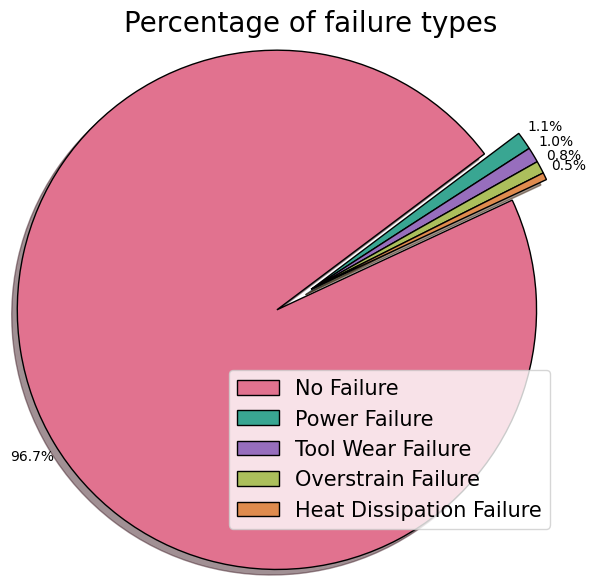

In [76]:
# 7) Pie-Chart - Percentage of failure types
columns_failure_type = dataset['Failure Type'].unique().tolist()  # Types of failures

plt.rcParams["figure.figsize"] = (6,6)
colors = ['#E1728F', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E']

plt.pie(dataset['Failure Type'].value_counts(), explode=(0.2, 0, 0, 0, 0), autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'}, counterclock=False, shadow=True, startangle=25,
        pctdistance=1.1, radius=1.3, colors=colors)
plt.legend(columns_failure_type, loc='lower right', fontsize=15)

plt.title('Percentage of failure types', fontsize=20)
plt.tight_layout()

### Features on Basis of each type of failure

Text(0.5, 1.0, 'Excluding class no failure')

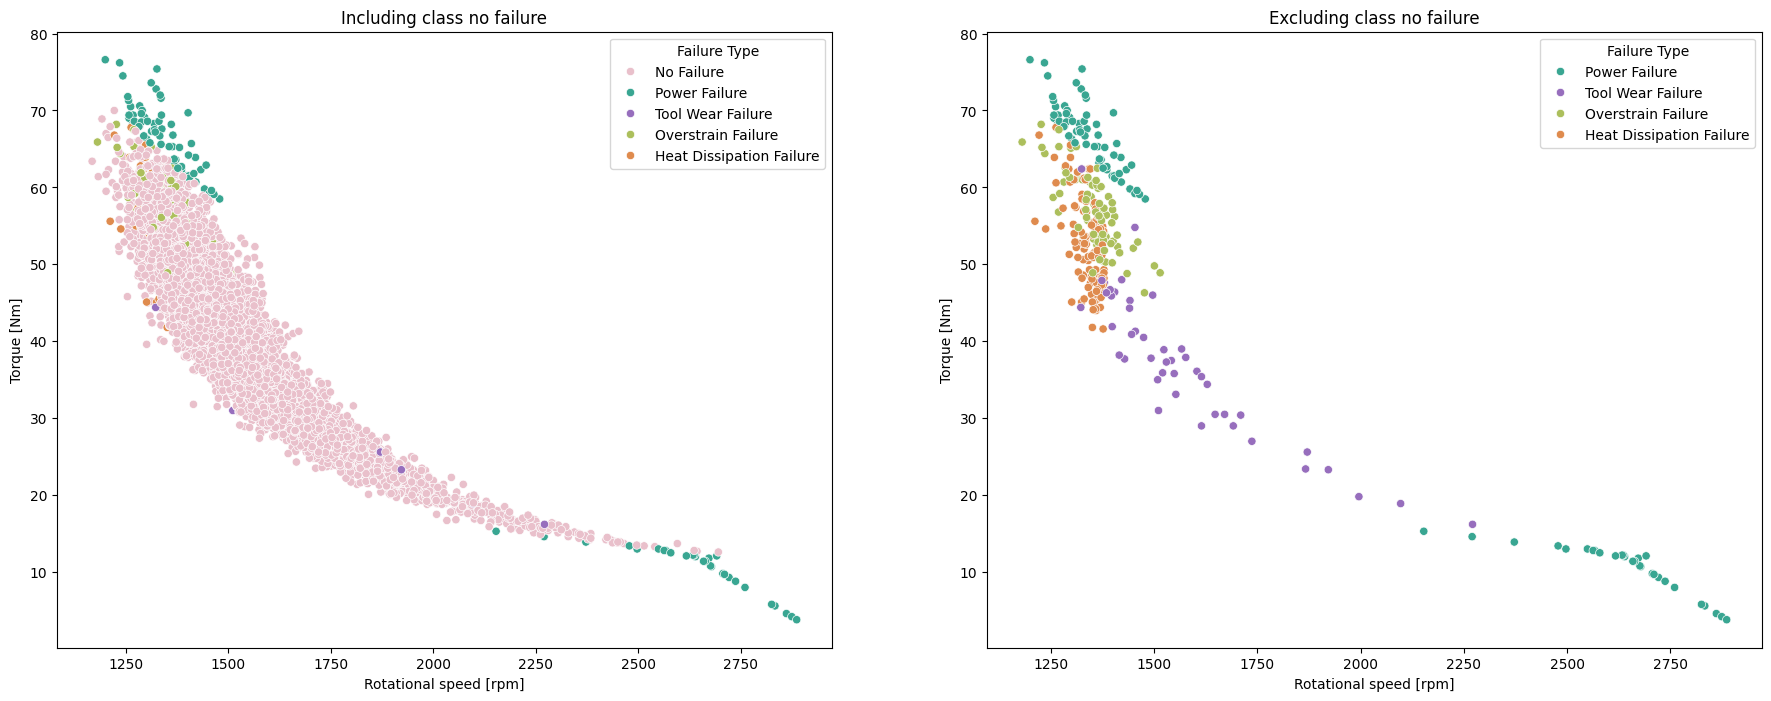

In [77]:
fig, ax = plt.subplots(1,2, figsize=[22,8])
plt.title('Rot. Speed vs Torque wrt Failure Type')
sns.scatterplot(data=dataset, x='Rotational speed [rpm]', y='Torque [Nm]', hue='Failure Type', palette=['#E9C0CB', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[0])
sns.scatterplot(data=dataset[dataset['Target'] == 1], x='Rotational speed [rpm]', y='Torque [Nm]', hue='Failure Type', palette=['#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[1])

ax[0].set_title('Including class no failure')
ax[1].set_title('Excluding class no failure')

### Distribution

----- SKEWNESS ------------
Air temperature [C] skewness = 0.12
Process temperature [C] skewness = 0.02
Rotational speed [rpm] skewness = 1.99
Torque [Nm] skewness = -0.01
Tool wear [min] skewness = 0.03
---------------------------


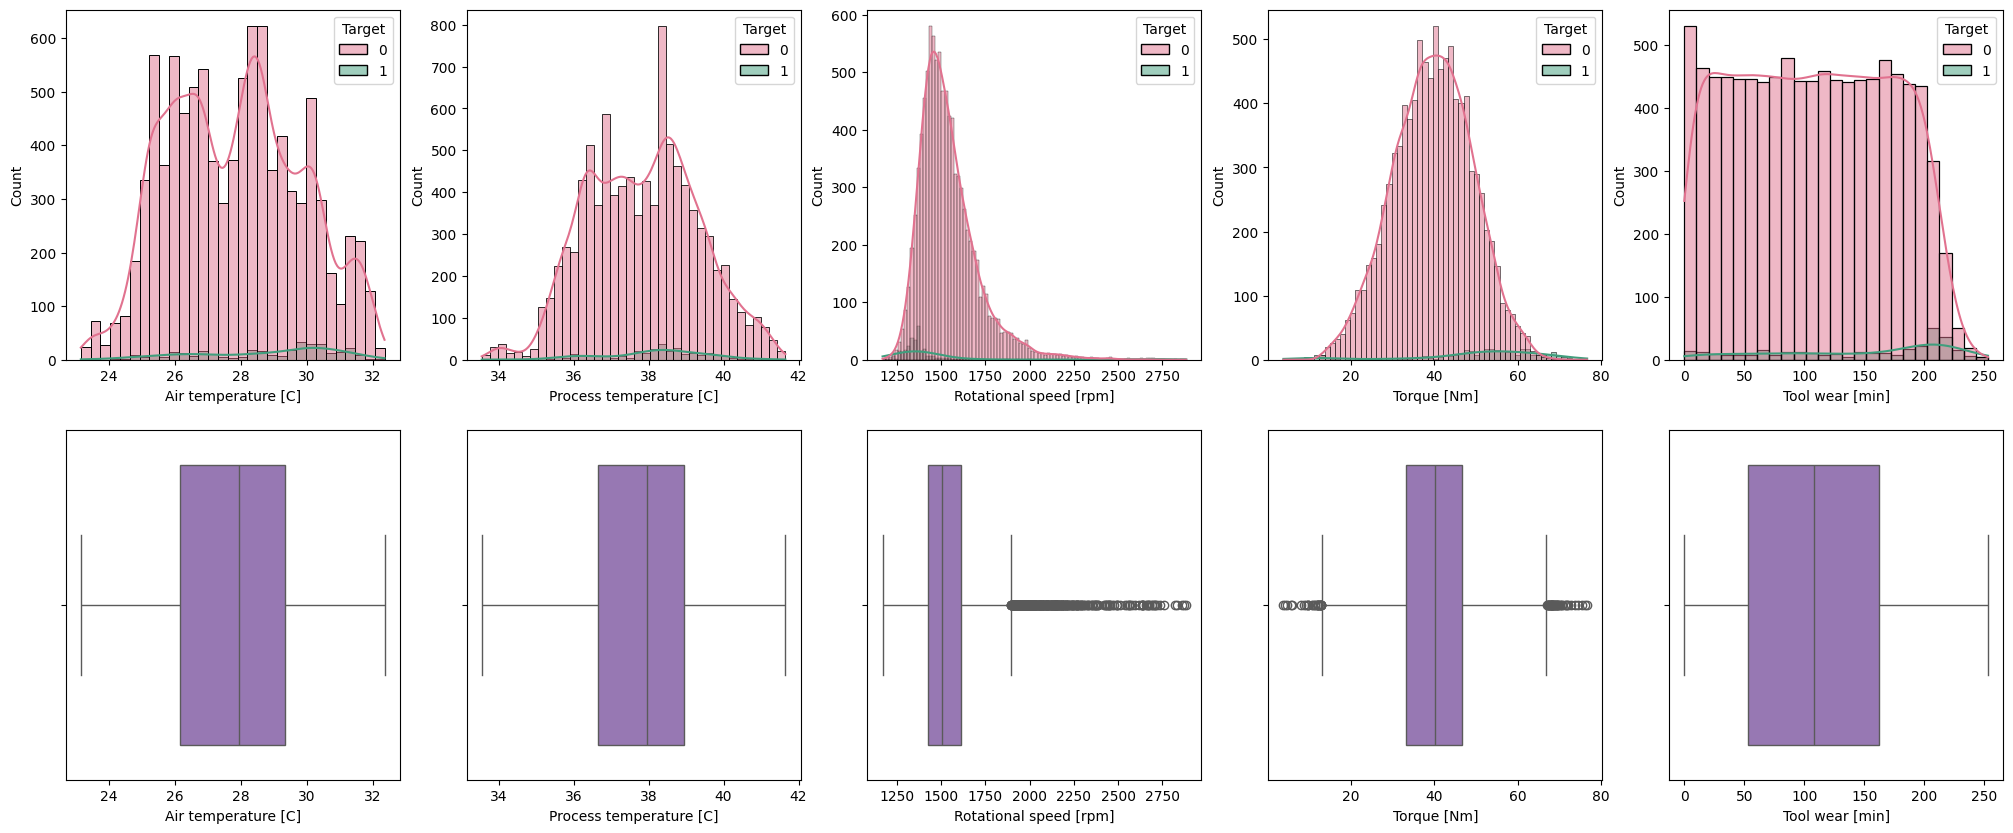

In [78]:
print('----- SKEWNESS ------------')
fig, axes = plt.subplots(2, 5, figsize=[25,10])
j = 0
colors = ['#E1728F', '#409E7D']

for i in ['Air temperature [C]', 'Process temperature [C]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']:
    sns.histplot(data=dataset, x=i, kde=True, ax=axes[0,j], hue='Target', palette=colors)
    sns.boxplot(data=dataset, x=i, ax=axes[1,j], palette=['#976EBD'])
    j+=1
    print('{} skewness = {}'.format(i, round(dataset[i].skew(), 2)))
print('---------------------------')

### Check for outliers

In [79]:
# Function to calculate the maximum and minumum value from the boxplot
def maximum_box(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    maximum = Q3 + 1.5*IQR
    minimum = Q1 - 1.5*IQR
    return maximum, minimum

for i in ['L', 'M', 'H']:
    df_product_type = dataset[dataset['Type'] == i]
    max_rotational_speed, min_rotational_speed = maximum_box(df_product_type['Rotational speed [rpm]'])
    max_torque, min_torque = maximum_box(df_product_type['Torque [Nm]'])
    print('Values from boxplot for type product ' + i + ':')
    print(f'Maximum torque value: {round(max_torque,2)}')
    print(f'Minimum torque value: {round(min_torque,2)}')
    print(f'Maximum rotational speed value: {round(max_rotational_speed,2)}')
    print(f'Minimum rotational speed value: {round(min_rotational_speed,2)}')
    print('='*20)

Values from boxplot for type product L:
Maximum torque value: 67.2
Minimum torque value: 12.8
Maximum rotational speed value: 1894.0
Minimum rotational speed value: 1142.0
Values from boxplot for type product M:
Maximum torque value: 67.05
Minimum torque value: 13.05
Maximum rotational speed value: 1895.75
Minimum rotational speed value: 1137.75
Values from boxplot for type product H:
Maximum torque value: 66.96
Minimum torque value: 12.66
Maximum rotational speed value: 1894.38
Minimum rotational speed value: 1143.38


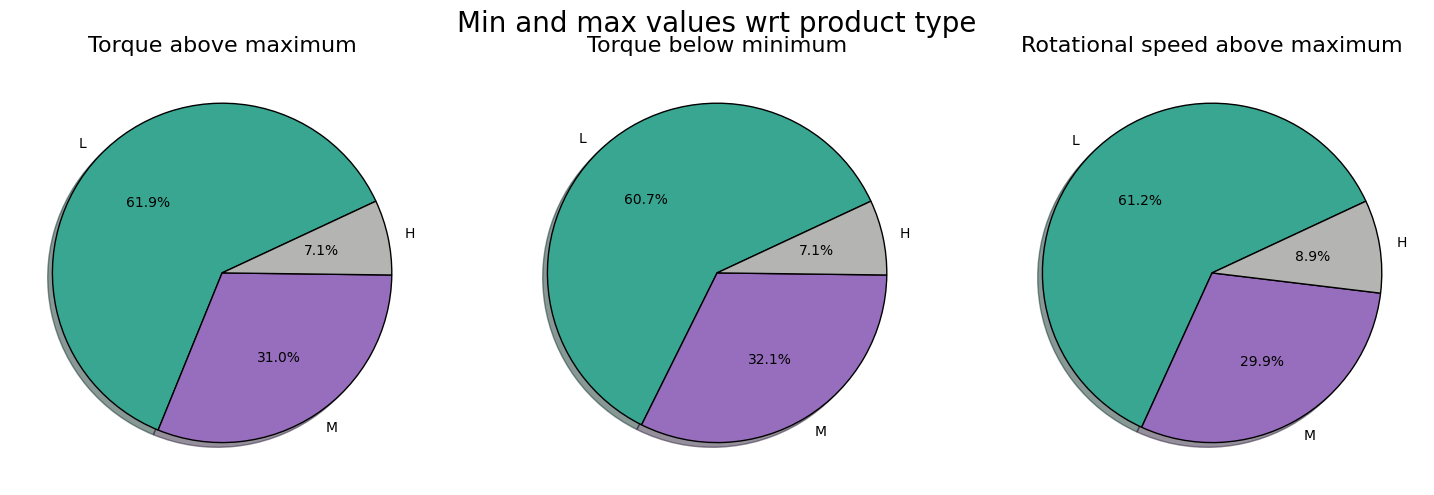

In [80]:
max_rotational_speed, min_rotational_speed = maximum_box(dataset['Rotational speed [rpm]'])
max_torque, min_torque = maximum_box(dataset['Torque [Nm]'])

max_torque_values = dataset[dataset['Torque [Nm]'] >= max_torque]['Type'].value_counts()  # Torque values above the boxplot maximum
min_torque_values = dataset[dataset['Torque [Nm]'] <= min_torque]['Type'].value_counts()  # Torque values below the boxplot minimum
max_rotational_speed_values = dataset[dataset['Rotational speed [rpm]'] >= max_rotational_speed]['Type'].value_counts()  # Rotational spede values above the boxplot maximum

fig, axes = plt.subplots(1,3, figsize=[15,5])
fig.suptitle('Min and max values wrt product type', fontsize=20)
plt.rcParams['axes.titlesize'] = 16
axes.flatten()
j=0
colors = ['#39A692', '#976EBD', '#B4B5B2']

for i in [max_torque_values, min_torque_values, max_rotational_speed_values]:
    axes[j].pie(i, labels=['L', 'M', 'H'], colors=colors,
        autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25)
    j+=1

axes[0].set_title('Torque above maximum')
axes[1].set_title('Torque below minimum')
axes[2].set_title('Rotational speed above maximum')
plt.tight_layout()

In [81]:
total_max_min_values = max_torque_values.sum() + min_torque_values.sum() + max_rotational_speed_values.sum()  # Total of instance under and above the minimum and maximum threshold from the boxplot, respectively.
ratio = total_max_min_values/dataset.shape[0]  # Percetange of these values with respect to the entire dataset
print('Percentage of values under and above the minimum and maximum threshold from the boxplot: {}'.format(ratio))

Percentage of values under and above the minimum and maximum threshold from the boxplot: 0.048932116715130855


## Data Preprocessing

In [82]:
columns_failure_type = dataset['Failure Type'].unique().tolist()

In [83]:
columns_failure_type


['No Failure',
 'Power Failure',
 'Tool Wear Failure',
 'Overstrain Failure',
 'Heat Dissipation Failure']

In [84]:
dataset

,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature Difference [C]
0,M,25.95,36.45,1551,42.8,0,0,No Failure,10.5
1,L,26.05,36.55,1408,46.3,3,0,No Failure,10.5
2,L,25.95,36.35,1498,49.4,5,0,No Failure,10.4
3,L,26.05,36.45,1433,39.5,7,0,No Failure,10.4
4,L,26.05,36.55,1408,40.0,9,0,No Failure,10.5
...,...,...,...,...,...,...,...,...,...
9995,M,26.65,36.25,1604,29.5,14,0,No Failure,9.6
9996,H,26.75,36.25,1632,31.8,17,0,No Failure,9.5
9997,M,26.85,36.45,1645,33.4,22,0,No Failure,9.6
9998,H,26.85,36.55,1408,48.5,25,0,No Failure,9.7


### Ordinal Encoding

In [85]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler

ord_enc = OrdinalEncoder(categories=[['L', 'M', 'H'], columns_failure_type])

# Fit and transform the data for feature 'Type' and target 'Failure Type'
new_dat = ord_enc.fit_transform(dataset[['Type', 'Failure Type']])
new_dat
dataset.drop(['Type', 'Failure Type'], axis=1, inplace=True)

new_df = pd.DataFrame(new_dat, 
                      index=dataset.index, 
                      columns=['Type', 'Failure Type'])

dataset = pd.concat([dataset, new_df], axis=1)

In [86]:
dataset

,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Temperature Difference [C],Type,Failure Type
0,25.95,36.45,1551,42.8,0,0,10.5,1.0,0.0
1,26.05,36.55,1408,46.3,3,0,10.5,0.0,0.0
2,25.95,36.35,1498,49.4,5,0,10.4,0.0,0.0
3,26.05,36.45,1433,39.5,7,0,10.4,0.0,0.0
4,26.05,36.55,1408,40.0,9,0,10.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...
9995,26.65,36.25,1604,29.5,14,0,9.6,1.0,0.0
9996,26.75,36.25,1632,31.8,17,0,9.5,2.0,0.0
9997,26.85,36.45,1645,33.4,22,0,9.6,1.0,0.0
9998,26.85,36.55,1408,48.5,25,0,9.7,2.0,0.0


### Scaling data

In [87]:
df_scaled = dataset.copy()

# Scaling Rotational speed and torque with robust scaler:
columns = ['Rotational speed [rpm]', 'Torque [Nm]']
scaler = RobustScaler()
features_scaled = scaler.fit_transform(dataset[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled,features_scaled], axis=1)

df_scaled

,Air temperature [C],Process temperature [C],Tool wear [min],Target,Temperature Difference [C],Type,Failure Type,Rotational speed [rpm],Torque [Nm]
0,25.95,36.45,0.0,0.0,10.5,1.0,0.0,0.253968,0.200000
1,26.05,36.55,3.0,0.0,10.5,0.0,0.0,-0.502646,0.459259
2,25.95,36.35,5.0,0.0,10.4,0.0,0.0,-0.026455,0.688889
3,26.05,36.45,7.0,0.0,10.4,0.0,0.0,-0.370370,-0.044444
4,26.05,36.55,9.0,0.0,10.5,0.0,0.0,-0.502646,-0.007407
...,...,...,...,...,...,...,...,...,...
6960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.894180,1.022222
7488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.703704,-0.422222
7868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.460317,0.274074
8506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.994709,1.140741


In [88]:
with open('scaler1.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [89]:
columns = ['Air temperature [C]', 'Process temperature [C]', 'Tool wear [min]']
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(dataset[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled, features_scaled], axis=1)

df_scaled

,Target,Temperature Difference [C],Type,Failure Type,Rotational speed [rpm],Torque [Nm],Air temperature [C],Process temperature [C],Tool wear [min]
0,0.0,10.5,1.0,0.0,0.253968,0.200000,0.304348,0.358025,0.000000
1,0.0,10.5,0.0,0.0,-0.502646,0.459259,0.315217,0.370370,0.011858
2,0.0,10.4,0.0,0.0,-0.026455,0.688889,0.304348,0.345679,0.019763
3,0.0,10.4,0.0,0.0,-0.370370,-0.044444,0.315217,0.358025,0.027668
4,0.0,10.5,0.0,0.0,-0.502646,-0.007407,0.315217,0.370370,0.035573
...,...,...,...,...,...,...,...,...,...
6960,NaN,NaN,NaN,NaN,-0.894180,1.022222,0.586957,0.654321,0.592885
7488,NaN,NaN,NaN,NaN,0.703704,-0.422222,0.565217,0.753086,0.007905
7868,NaN,NaN,NaN,NaN,-0.460317,0.274074,0.608696,0.864198,0.442688
8506,NaN,NaN,NaN,NaN,-0.994709,1.140741,0.358696,0.456790,0.110672


In [90]:
with open('scaler2.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [91]:
df_scaled = df_scaled.dropna()
df_scaled = df_scaled.reset_index(drop=True)

In [92]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9946 entries, 0 to 9945
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Target                      9946 non-null   float64
 1   Temperature Difference [C]  9946 non-null   float64
 2   Type                        9946 non-null   float64
 3   Failure Type                9946 non-null   float64
 4   Rotational speed [rpm]      9946 non-null   float64
 5   Torque [Nm]                 9946 non-null   float64
 6   Air temperature [C]         9946 non-null   float64
 7   Process temperature [C]     9946 non-null   float64
 8   Tool wear [min]             9946 non-null   float64
dtypes: float64(9)
memory usage: 699.5 KB


## Saving Dataset

In [93]:
df_scaled.to_csv('cleaned_dataset.csv', index=False)

In [94]:
df_scaled['Failure Type'].unique()

array([0., 1., 2., 3., 4.])

## Modeling with 'Target' variable

### Stratified Split

In [95]:
X = df_scaled.drop(['Target', 'Failure Type'], axis=1)
y = df_scaled['Target']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

print('Checking the stratified split...')
print('Target proportion in original dataset:')
print(dataset['Target'].value_counts(normalize=True))

print('Target proportion in y_train dataset:')
print(y_train.value_counts(normalize=True))

print('Target proportion in y_test dataset:')
print(y_test.value_counts(normalize=True))

Checking the stratified split...
Target proportion in original dataset:
Target
0    0.966911
1    0.033089
Name: proportion, dtype: float64
Target proportion in y_train dataset:
Target
0.0    0.966886
1.0    0.033114
Name: proportion, dtype: float64
Target proportion in y_test dataset:
Target
0.0    0.967029
1.0    0.032971
Name: proportion, dtype: float64


In [96]:
y_test

2249    0.0
552     0.0
2133    0.0
9353    0.0
1343    0.0
       ... 
3771    0.0
9518    0.0
704     0.0
2349    0.0
8281    0.0
Name: Target, Length: 2487, dtype: float64